 The following chunk gets input and spits out "cities" variable that is a pandas dataframe of cities inputed that also has "n_people" column

In [1]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
# Get Input
df = pd.read_csv ('world_cities_modified.csv')
cities = pd.DataFrame(columns = ["index","city","city_ascii","lat","lng","country","iso2","iso3","admin_name","capital","population","id","gmtOffset"])
n_people = []

print("Enter two zeros (0 0) to end")

while True:
    inp = input("Enter the name of the city: ")
    if inp == "0 0":
        break
    rslt_df = df[df["city_ascii"] == inp]
    id = 1
    if rslt_df.shape[0] > 1:
        for index, row in rslt_df.iterrows():
            print(f"{id}: Did you mean {row['city_ascii']}, {row['admin_name']}, {row['country']}")
            id += 1
        id = int(input("Enter the ID associated with the city: "))

    n_people.append(int(input("Enter the number of people from that city: ")))
    cities.loc[len(cities)] = rslt_df.iloc[id-1]

cities["n_people"] = n_people 

# print(cities)

Enter two zeros (0 0) to end
1: Did you mean Moscow, Moskva, Russia
2: Did you mean Moscow, Idaho, United States
1: Did you mean Lisbon, Lisboa, Portugal
2: Did you mean Lisbon, Maine, United States
3: Did you mean Lisbon, Ohio, United States
1: Did you mean London, London, City of, United Kingdom
2: Did you mean London, Ontario, Canada
3: Did you mean London, Kentucky, United States
4: Did you mean London, Ohio, United States


The following  two chunks of code is the algorithm that we are using 
(Needs to change)

In [2]:
a = {}

## Create a nested dictionary that holds data about each city
## info can be accessed by the id
for index, row in cities.iterrows():
    a[index] = {"name": row['city_ascii'], "gmtOffset": row['gmtOffset'], "list": [], "people": row['n_people']}
# for i in a.values():
#     i['people'] = people[cities.index(i['name'])]
idx = a.keys()

# Caculate time difference between the given cities and every other city
for index, row in df.iterrows():
    for i in a.keys():
        a[i]['list'].append((a[i]['gmtOffset']*a[i]['people']) - (row['gmtOffset']*a[i]['people']))

# Add gmt differenc to a dataframe
for key in a:
    df[key] = a[key]['list']

In [3]:
sum = []

## Add a sum column where we sum the jet lag
## We are using absolute value because We want to
## find values closest to zero by using min() function
for index, row in df.iterrows():
    total = 0
    for i in idx:
        total += row[i]
    sum.append(abs(total))

df['sum'] = sum

The above two cells are our algorithm that should spit out variable "df" that is a dataframe of all (42k) cities that has column "sum"

In [4]:
# Get the dataframe of cities where the sum of jet lag is the least (there are multiple of them)
least = float(df.nsmallest(1, 'sum')['sum'])
possible_locations = df[df["sum"] == least]

In [5]:
import geopy.distance

a = {}
for index, row in cities.iterrows():
    a[index] = {"name": row['city_ascii'], "gmtOffset": row['gmtOffset'], "list": [], "people": row['n_people']}
idx = a.keys()


for i_cities, row_cities in cities.iterrows():
    for i_pl, row_pl in possible_locations.iterrows():
        a[i_cities]['list'].append(geopy.distance.geodesic((row_cities["lat"], row_cities["lng"]), (row_pl["lat"], row_pl["lng"])).km)
        

In [6]:
new = [0 for i in range(len(possible_locations))]

for key in a:
    new = [a+b for a, b in zip(new, a[key]['list'])]

final_location = possible_locations.iloc[[new.index(min(new))]]

/tmp/ipykernel_100295/2573587300.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cities = cities.append(pd.Series(final_location.values.tolist()[0], index=cities.columns[:len(final_location.values.tolist()[0])]), ignore_index=True)


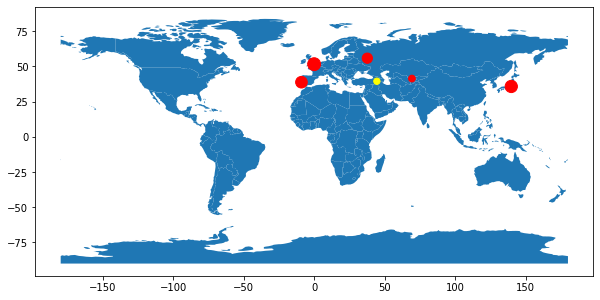

In [7]:
people = [i*15 for i in list(cities['n_people'])]
colors = ['red' for i in range(len(people))]
people.append(40)
colors.append('yellow')

cities = cities.iloc[: , :13]
final_location = final_location.iloc[: ,:13]

cities = cities.append(pd.Series(final_location.values.tolist()[0], index=cities.columns[:len(final_location.values.tolist()[0])]), ignore_index=True)
geometry = [Point(xy) for xy in zip(cities['lng'], cities['lat'])]
gdf      = GeoDataFrame(cities, geometry=geometry)

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# gdf_final.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='green', markersize=20);
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color=colors, markersize=people);

In [18]:
print(f"The perfect location for a conference that minimizes jet lag is {final_location['city_ascii'].values[0]}, {final_location['admin_name'].values[0]}, {final_location['country'].values[0]}.")

The perfect location for a conference that minimizes jet lag is Bazargan, Āz̄arbāyjān-e Gharbī, Iran
